In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")

import common_functions as cf

## Import Data

In [7]:
df_all = pd.read_pickle("merged_w_df.pkl")

In [8]:
df_all.shape

(128500, 15)

In [9]:
#np.asarray(df_all).reshape(2570,50,15)

In [10]:
# import pickle
# with open('merged_w_arr.pkl','rb') as f:
#     arr_all = pickle.load(f)
# arr_all.shape

In [11]:
df_all.head(2)

,rotR_x,rotR_y,rotR_z,acc_x,acc_y,acc_z,or_x,or_y,or_z,grav_x,grav_y,grav_z,action,label,action_num
time,,,,,,,,,,,,,,,
0,-12.012195,5.243902,1.158537,0.098145,0.047607,0.029785,15,13,80,0.271240,-0.230225,0.934326,t_stand_left_DrinkBottle_10ml_1s_right,1,0
1,-23.780488,17.195122,3.658537,0.093994,0.043213,0.041748,15,14,80,0.259766,-0.249023,0.932861,t_stand_left_DrinkBottle_10ml_1s_right,1,0


# Feature engineering (basic)

In [12]:
df_fe = cf.fe_basic_features(df_all)

In [13]:
df_fe.head(2)

,accel_norm,rotR_x,rotR_y,rotR_z,acc_x,acc_y,acc_z,or_x,or_y,or_z,grav_x,grav_y,grav_z,action,label,action_num
time,,,,,,,,,,,,,,,,
0,1.048477,-12.012195,5.243902,1.158537,0.098145,0.047607,0.029785,15,13,80,0.271240,-0.230225,0.934326,t_stand_left_DrinkBottle_10ml_1s_right,1,0
1,1.057056,-23.780488,17.195122,3.658537,0.093994,0.043213,0.041748,15,14,80,0.259766,-0.249023,0.932861,t_stand_left_DrinkBottle_10ml_1s_right,1,0


In [14]:
df_fe.shape

(128500, 16)

## Data Splitting(Test/train)

In [15]:
train_df,test_df = cf.data_split_TrainTest(df_fe)

In [16]:
train_df.shape,test_df.shape

((72150, 16), (56350, 16))

## Preprocess (Normalizing)

In [17]:
from sklearn.preprocessing import StandardScaler
last_feat_column = df_fe.columns[-4]

for act_num in train_df.action_num.unique():
    std = StandardScaler().set_output(transform='pandas')
    
    train_df_w_act_num = train_df.loc[train_df.action_num == act_num,:last_feat_column].copy()
    std.fit(train_df_w_act_num)
    train_df.loc[train_df.action_num == act_num,:last_feat_column] = std.transform(train_df_w_act_num)


for act_num in test_df.action_num.unique():
    std = StandardScaler().set_output(transform='pandas')
    
    test_df_w_act_num = test_df.loc[test_df.action_num == act_num,:last_feat_column].copy()
    std.fit(test_df_w_act_num)
    test_df.loc[test_df.action_num == act_num,:last_feat_column] = std.transform(test_df_w_act_num)

In [18]:
train_df.shape,test_df.shape

((72150, 16), (56350, 16))

In [19]:
#X_train_roll = cf.pre_normalize_tanh(X_train_roll)
#X_test_roll = cf.pre_normalize_tanh(X_test_roll)

## Modeling

### Split Data (Feature/Label)

In [99]:
def load_dataset():
    X_train,y_train = cf.data_split_FeatLabel(train_df)
    X_test,y_test = cf.data_split_FeatLabel(test_df)
   
    X_train = np.asarray(X_train).reshape(int(X_train.shape[0]/cf.SEQUENCE_SIZE) , cf.SEQUENCE_SIZE, X_train.shape[1])
    y_train = np.asarray(y_train).reshape(int(y_train.shape[0]/cf.SEQUENCE_SIZE) , cf.SEQUENCE_SIZE)

    X_test = np.asarray(X_test).reshape(int(X_test.shape[0]/cf.SEQUENCE_SIZE) , cf.SEQUENCE_SIZE, X_test.shape[1])
    y_test = np.asarray(y_test).reshape(int(y_test.shape[0]/cf.SEQUENCE_SIZE) , cf.SEQUENCE_SIZE)

    return  X_train,y_train,X_test,y_test

In [100]:
# load data
trainX, trainy, testX, testy = load_dataset()

In [103]:
n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
n_outputs =1

# reshape data into time steps of sub-sequences
n_steps = 2
n_length = int(cf.SEQUENCE_SIZE/n_steps) 

trainX_resh = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX_resh = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

In [102]:
trainy.shape

(72150,)

### Neurel Network

In [104]:


from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Flatten,Dropout,LSTM,TimeDistributed,MaxPooling1D,Conv1D

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
import sklearn
tf.random.set_seed(20) # to fix the randomization
np.random.seed(20)# to fix the randomizationin sklearn
sklearn.random.seed(1)

In [105]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=10, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=10, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
print(model.summary())


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_80 (TimeDi  (None, None, 23, 10)     400       
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, None, 21, 10)     310       
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, None, 21, 10)     0         
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, None, 10, 10)     0         
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, None, 100)      

In [106]:
opt = keras.optimizers.Adam(learning_rate=0.02)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

X_train, val_X, y_train, val_y = train_test_split(trainX_resh, trainy, shuffle=True,test_size=0.2 )

ValueError: Found input variables with inconsistent numbers of samples: [1443, 72150]

In [94]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model_LSTM.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=250,validation_data=(val_X,val_y),callbacks=[es,mc])

Epoch 1/50
4/5 [=======================>......] - ETA: 0s - loss: 0.6886 - accuracy: 0.0040 
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model_LSTM.h5
5/5 [==============================] - 8s 437ms/step - loss: 0.6877 - accuracy: 0.0035 - val_loss: 0.6486 - val_accuracy: 0.0000e+00
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 0.6292 - accuracy: 0.0010    
Epoch 2: val_accuracy did not improve from 0.00000
5/5 [==============================] - 0s 41ms/step - loss: 0.6290 - accuracy: 8.6655e-04 - val_loss: 0.5710 - val_accuracy: 0.0000e+00
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.5431 - accuracy: 0.0170
Epoch 3: val_accuracy improved from 0.00000 to 0.00346, saving model to best_model_LSTM.h5
5/5 [==============================] - 0s 73ms/step - loss: 0.5516 - accuracy: 0.0147 - val_loss: 0.5360 - val_accuracy: 0.0035
Epoch 4/50
3/5 [=================>............] - ETA: 0s - loss: 0.4954 - accuracy: 0.0413


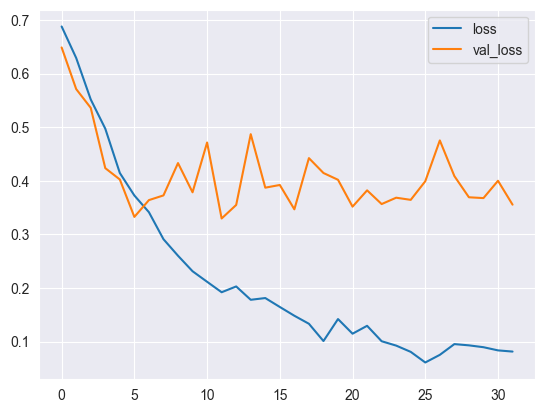

In [95]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss',"val_loss"]].plot()
plt.show()

#### Evaluate

In [96]:
best_saved_model = load_model('best_model_LSTM.h5')
_, train_acc = best_saved_model.evaluate(trainX_resh, trainy, verbose=0)
_, test_acc = best_saved_model.evaluate(testX_resh, testy, verbose=0)
print('Train: %.2f, Test: %.2f' % (train_acc*100, test_acc*100))

Train: 8.73, Test: 10.03
